Code for HW 3

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom
import time


In [10]:
def SIS_norm(s0,i0, beta, gamma, t_max, stepsize):
    T = np.arange(0,t_max+stepsize,stepsize)
    s = np.zeros(len(T))
    i = np.zeros(len(T))
    
    for idx,t in enumerate(T):
        if idx==0:
            s[idx] = s0
            i[idx] = i0
        else:
            dS_dt = -beta * s[idx-1] * i[idx-1] + gamma * i[idx-1]
            dI_dt = beta * s[idx-1] * i[idx-1] - gamma * i[idx-1]
            
            s[idx] = s[idx-1] + dS_dt * stepsize
            i[idx] = i[idx-1] + dI_dt * stepsize
    
    return s, i, T

def SIR_group(s0, i0, p, c_bar, gamma, t_max, dt):
    n_groups = len(p)
    T = np.arange(0, t_max + dt, dt)
    
    S = np.zeros((len(T), n_groups))
    I = np.zeros((len(T), n_groups))
    R = np.zeros((len(T), n_groups))
    
    S[0, :] = s0
    I[0, :] = i0
    
    for t in range(1, len(T)):
        total_I = np.sum(I[t-1, :])  # fully mixed
        
        dS = -p * c_bar * S[t-1, :] * total_I
        dI = p * c_bar * S[t-1, :] * total_I - gamma * I[t-1, :]
        dR = gamma * I[t-1, :]
        
        S[t, :] = S[t-1, :] + dS * dt
        I[t, :] = I[t-1, :] + dI * dt
        R[t, :] = R[t-1, :] + dR * dt

    return S, I, R, T

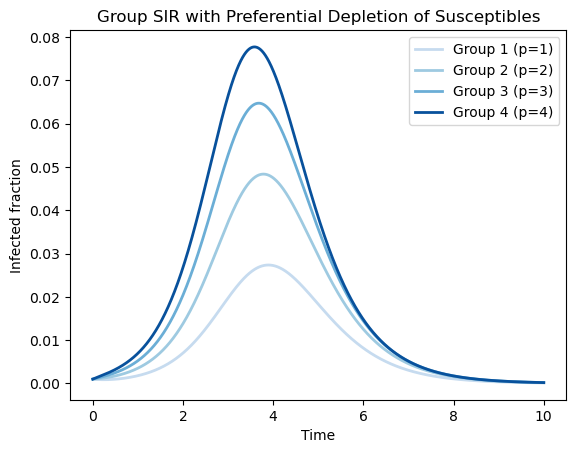

In [11]:
# question 1.d

p = np.array([1, 2, 3, 4])
gamma = 3.0
R0 = 1.5
s0 = np.ones(4) * 0.999
i0 = np.ones(4) * 0.001

c_bar = (R0 * gamma) / np.sum(p * s0)

S, I, R, T = SIR_group(s0, i0, p, c_bar, gamma, t_max=10, dt=0.001)

colors = ['#c6dbef', '#9ecae1', '#6baed6', '#08519c']
for i in range(4):
    plt.plot(T, I[:, i], color=colors[i], linewidth=2, label=f'Group {i+1} (p={p[i]})')

plt.xlabel('Time')
plt.ylabel('Infected fraction')
plt.title('Group SIR with Preferential Depletion of Susceptibles')
plt.legend()
plt.savefig("1d.pdf")
plt.show()

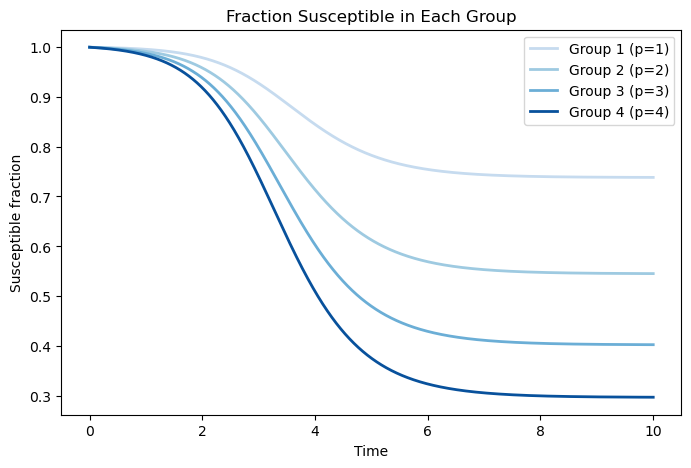

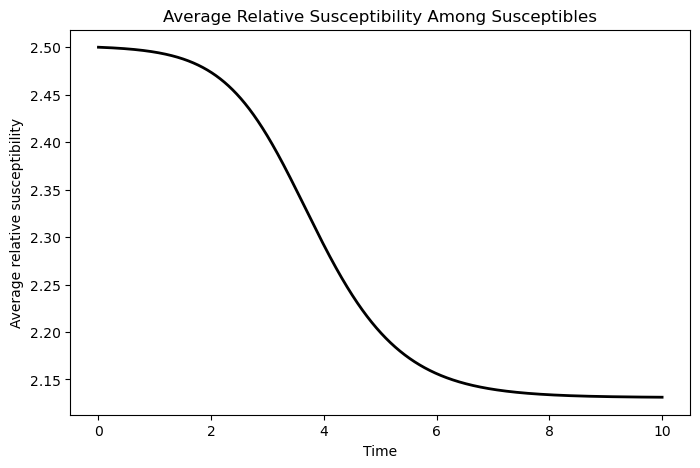

In [12]:
# question 1.e

p_bar = np.sum(p * S, axis=1) / np.sum(S, axis=1)

plt.figure(figsize=(8,5))
colors = ['#c6dbef', '#9ecae1', '#6baed6', '#08519c']
for i in range(4):
    plt.plot(T, S[:, i], color=colors[i], linewidth=2, label=f'Group {i+1} (p={p[i]})')
plt.xlabel('Time')
plt.ylabel('Susceptible fraction')
plt.title('Fraction Susceptible in Each Group')
plt.legend()
plt.savefig("1e1.pdf")
plt.show()
plt.close()

plt.figure(figsize=(8,5))
plt.plot(T, p_bar, color='black', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Average relative susceptibility')
plt.title('Average Relative Susceptibility Among Susceptibles')
plt.savefig("1e2.pdf")
plt.show()
plt.close()

In [ ]:
# 2.a

# notes from hw

# k = 10000 # Dispersion Parameter k
# R0 = 3 # Mean R0
# mean = R0
# variance = mean + (mean**2)/k
# p = mean/variance
# n = mean**2 / (variance - mean)
# draw = nbinom.rvs(n=n,p=p)
# draws = nbinom.rvs(n=n,p=p,size=10)

def branching_process_simulation(R0, k, G=100, trials=10000, seed=0, MAX_POP=10000):
    rng = np.random.default_rng(seed)
    n = k
    p = k / (k + R0)
    extinctions = 0
    
    for _ in range(trials):
        current_gen = 1
        for _ in range(G):
            if current_gen == 0:
                extinctions += 1
                break
            if current_gen > MAX_POP:
                break
            current_gen = nbinom.rvs(n=n, p=p, size=current_gen, random_state=rng).sum()
    return extinctions / trials

# Example run
k_values = [0.1, 0.5, 1.0, 5.0, 10.0]
results = []

for k in k_values:
    start = time.time()
    q = branching_process_simulation(R0=3, k=k, trials=50000, G=100, MAX_POP=10000)
    end = time.time()
    print(f"k={k:4.1f} → q={q:.3f} (runtime {end - start:.2f}s)")
    results.append((k, q))

k= 0.1 → q=0.837 (runtime 4.13s)
k= 0.5 → q=0.499 (runtime 16.89s)
k= 1.0 → q=0.337 (runtime 14.75s)
k= 5.0 → q=0.117 (runtime 21.94s)
k=10.0 → q=0.088 (runtime 22.48s)


k=0.1: median=1, 90th=2, 99th=16, min=1, max=140


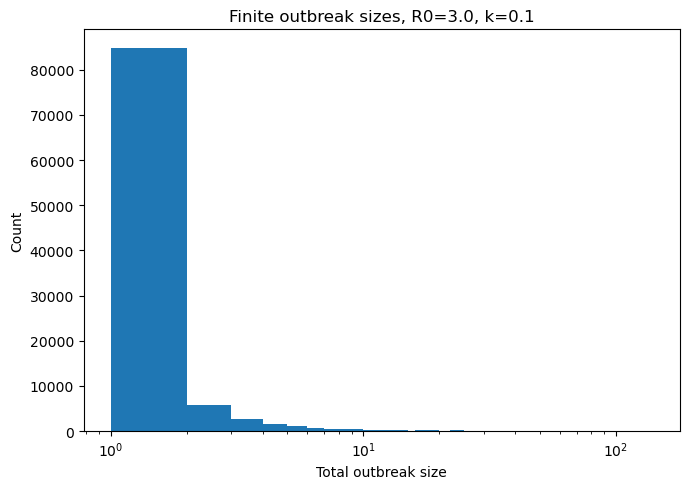

k=0.5: median=1, 90th=3, 99th=9, min=1, max=36


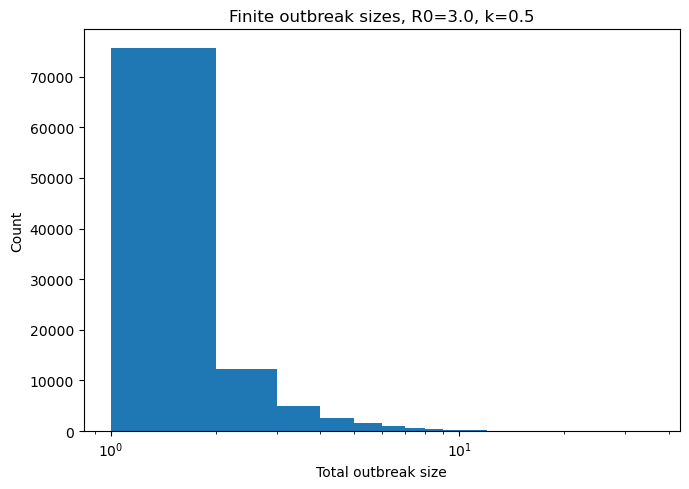

k=1.0: median=1, 90th=3, 99th=7, min=1, max=23


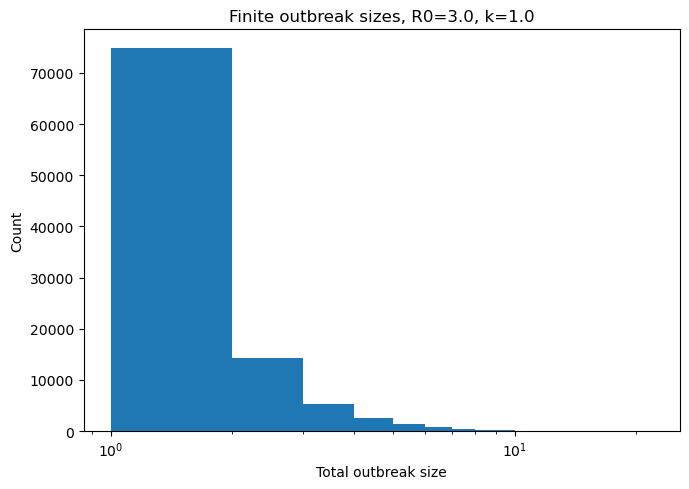

k=5.0: median=1, 90th=2, 99th=4, min=1, max=13


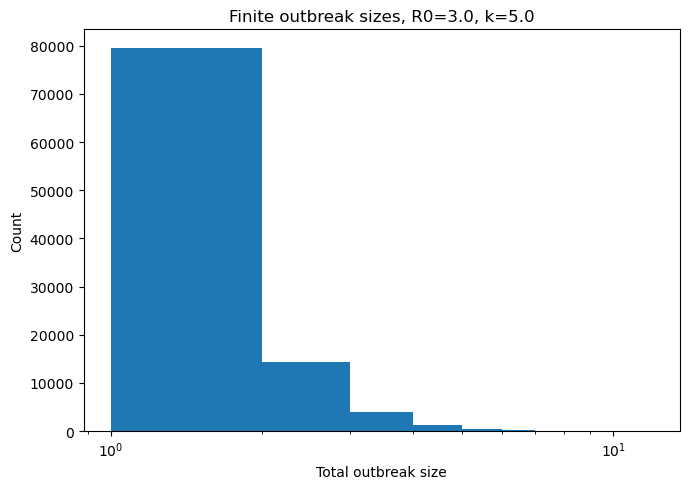

k=10.0: median=1, 90th=2, 99th=4, min=1, max=12


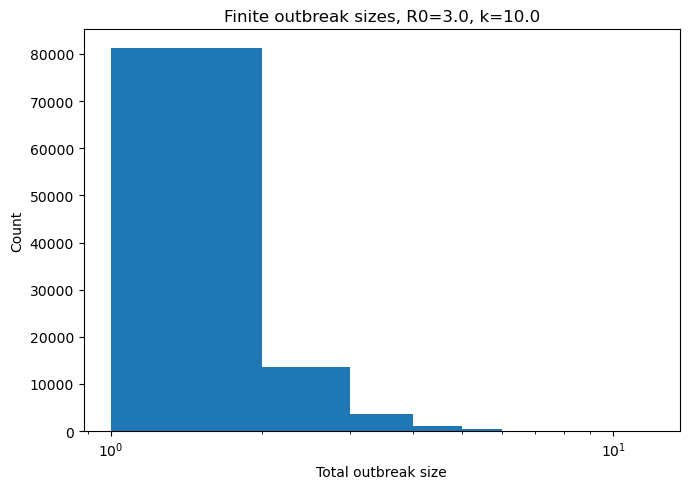

In [19]:
#2.grad

def draw_offspring(R0, k, size, rng):
    n = k
    p = k / (k + R0)
    return nbinom.rvs(n=n, p=p, size=size, random_state=rng)

def sample_finite_outbreak_sizes(R0=3.0, k=0.1, target=100_000, 
                                 G_max=2000, MAX_POP=10_000, seed=0):
    rng = np.random.default_rng(seed)
    sizes = []
    while len(sizes) < target:
        total = 1
        gen = 1
        for _ in range(G_max):
            if gen == 0:
                sizes.append(total)
                break
            if gen > MAX_POP or total > MAX_POP:
                break
            gen = draw_offspring(R0, k, gen, rng).sum()
            total += gen
    return np.array(sizes, dtype=int)

R0 = 3.0
k_list = [0.1, 0.5, 1.0, 5.0, 10.0]

for k in k_list:
    sizes = sample_finite_outbreak_sizes(R0=R0, k=k, target=100_000, 
                                         G_max=2000, MAX_POP=10_000, seed=123)
    q_est = len(sizes) / (len(sizes))
    median = np.median(sizes)
    p90 = np.percentile(sizes, 90)
    p99 = np.percentile(sizes, 99)
    print(f"k={k}: median={median:.0f}, 90th={p90:.0f}, 99th={p99:.0f}, min={sizes.min()}, max={sizes.max()}")

    lo = max(1, sizes.min())
    hi = sizes.max()
    bins = np.unique(np.logspace(np.log10(lo), np.log10(hi), 50).astype(int))

    plt.figure(figsize=(7,5))
    plt.hist(sizes, bins=bins)
    plt.xscale('log')
    plt.xlabel('Total outbreak size')
    plt.ylabel('Count')
    plt.title(f'Finite outbreak sizes, R0={R0}, k={k}')
    plt.tight_layout()
    plt.savefig(f'finite_sizes_R0{int(R0)}_k{k}.png', dpi=200)
    plt.show()